In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

13.962634015954636


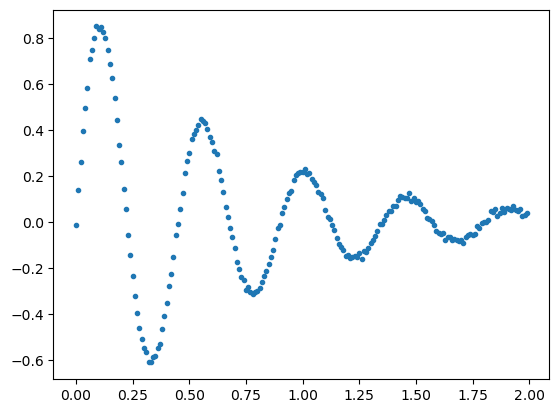

In [2]:
# generate simulated data
Npts = 200
dt = 0.01
ts = torch.arange(Npts) * dt
alpha0 = 1.5
omega0 = 2 * np.pi / 0.45
zn = torch.sin(omega0 * ts) * torch.exp(-alpha0 * ts)
zn += 0.01 * torch.randn(Npts)
plt.plot(ts, zn, '.')
print(omega0)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
zn = zn.to(device)
xn = torch.ones((2, Npts), device=device, requires_grad=True)
omega_t = torch.ones([2], device=device, requires_grad=True)


cuda


In [4]:
# damped simple harmonic oscillator model dx / df = f(x, omega)
def f(x, omega):
    f1 = x[1, :]
    f2 = - omega[0]**2 * x[0, :] - 2 * omega[1] * x[1, :]
    f = torch.stack([f1, f2], dim=0)
    return f

In [5]:
optim = torch.optim.Adam(params=[xn, omega_t], lr=0.01)
param_history = []
model_weight = 100  # try starting with this small and gradually increase durning optimization to try to avoid local mins
for niter in range(50000):
    optim.zero_grad()
    # average of forward and backward euler
    error_model_n = xn[:, 1:] - xn[:, :-1] - 0.5 * dt * (f(xn[:, :-1], omega_t)  + f(xn[:, 1:], omega_t)) 
    loss_model = torch.mean( error_model_n ** 2) 
    loss_obs = torch.mean( (xn[0, :] - zn) ** 2)
    loss_total = model_weight * loss_model + loss_obs
    if niter % 1000 == 0:
        print(niter, loss_total.item(), loss_model.item(), loss_obs.item(), omega_t[0].item(), omega_t[1].item())
        param_history.append(omega_t.tolist())
    loss_total.backward()
    optim.step()

0 1.059153437614441 0.0004999999655410647 1.0091534852981567 1.0 1.0
1000 0.03440718352794647 0.00017335602024104446 0.01707158423960209 0.7987139821052551 -0.16333311796188354
2000 0.0331445038318634 0.00016691333439666778 0.016453169286251068 2.094578266143799 -0.3283296823501587
3000 0.025019841268658638 0.000130667511257343 0.011953090317547321 6.4375152587890625 0.9551735520362854
4000 0.01314164511859417 6.5183499827981e-05 0.006623294670134783 9.927641868591309 1.5205479860305786
5000 0.006782070733606815 3.217606354155578e-05 0.003564464161172509 11.548861503601074 1.512352705001831
6000 0.0036447937600314617 1.671924655965995e-05 0.001972869271412492 12.404897689819336 1.4764447212219238
7000 0.0020338441245257854 9.066360689757857e-06 0.0011272080009803176 12.919504165649414 1.4576860666275024
8000 0.0011831822339445353 5.171101747691864e-06 0.0006660721264779568 13.252191543579102 1.4495856761932373
9000 0.0006991567788645625 2.826687477863743e-06 0.0004164880665484816 13.47

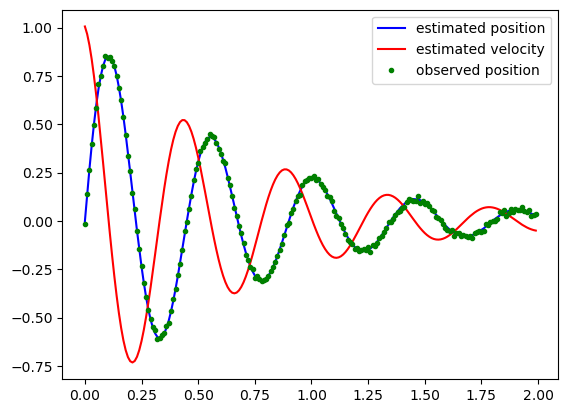

In [6]:
plt.plot(ts, xn[0, :].detach().cpu().numpy(), 'b-', label='estimated position')
plt.plot(ts, xn[1, :].detach().cpu().numpy() /omega0, 'r-', label='estimated velocity')
plt.plot(ts, zn.detach().cpu().numpy(), 'g.', label='observed position')
plt.legend()

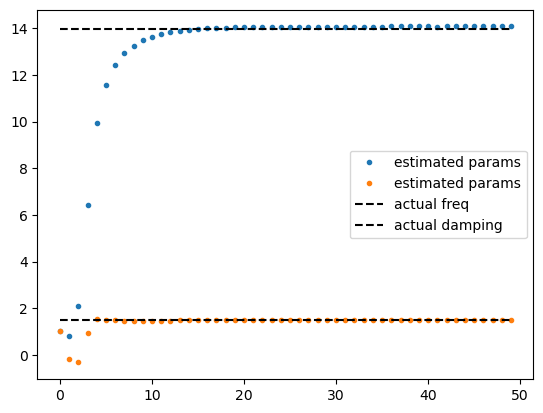

In [8]:
plt.plot(param_history, '.', label='estimated params')
plt.plot([0, len(param_history)-1], [omega0, omega0], 'k--', label='actual freq')
plt.plot([0, len(param_history)-1], [alpha0, alpha0], 'k--', label='actual damping')
plt.legend()
